In [7]:
import numpy as np
import random
from implementations import *
from proj1_helpers import *
from features_eng import *
from plots import *
from helpers import *
from preprocessing import *
from cross_validation import *

%load_ext autoreload
%autoreload 2

In [8]:
LOWER_BOUND = -1
UPPER_BOUND = 1

# Import data

In [9]:
DATA_FOLDER = "competition-data/"
DATA_TEST = "test.csv"
DATA_TRAIN = "train.csv"
y_train, x_train, ids_train = load_csv_data(DATA_FOLDER + DATA_TRAIN, LOWER_BOUND, UPPER_BOUND)
tx_train = x_train.T

In [10]:
# Create inverse log values of features which are positive in value.
inv_log_cols = [0, 2, 5, 7, 9, 10, 13, 16, 19, 21, 23, 26]

tx_train_inv_log_cols = np.log(1 / (1 + tx_train[inv_log_cols]))
tx_train = np.vstack((tx_train, tx_train_inv_log_cols))
tx_train.shape

(42, 250000)

In [11]:
# Code to plot correlations between features

"""
import matplotlib.pyplot as plt
import numpy as np

for i in range(29):
    for j in range(i+1, 30):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        x = tx_train[:,tx_train[22] == 1][i]
        y = tx_train[:,tx_train[22] == 1][j]
        plt.xlabel('Feature %d' % i)
        plt.ylabel('Feature %d' % j)
        ax.scatter(x, y)
        plt.show()
"""

'''
for j in range(0, 30):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    x = tx_train[22]
    y = tx_train[j]
    plt.xlabel('Feature %d' % 22)
    plt.ylabel('Feature %d' % j)
    ax.scatter(x, y)
    plt.show()
'''

"\nfor j in range(0, 30):\n    fig = plt.figure()\n    ax = fig.add_subplot(1, 1, 1)\n    x = tx_train[22]\n    y = tx_train[j]\n    plt.xlabel('Feature %d' % 22)\n    plt.ylabel('Feature %d' % j)\n    ax.scatter(x, y)\n    plt.show()\n"

# Cleaning data

In [12]:
# Balance the data set to have the same number of 1 that -1 (downsample)
'''
tx_train, y_train = balance(tx_train.T, y_train, LOWER_BOUND, UPPER_BOUND)
tx_train.shape
'''

'\ntx_train, y_train = balance(tx_train.T, y_train, LOWER_BOUND, UPPER_BOUND)\ntx_train.shape\n'

In [13]:
# Separate into 4 sets depending on the feature 22: 'PRI_jet_num' (categorical feature)
masks_jet_train = get_jet_masks(tx_train.T)

In [14]:
# Replace remaining NaN values with the median of the column + standardie the values of all features
tx_train = replace_nan_by_median(tx_train)
mean_train, std_train, tx_train = standardize(tx_train)

In [15]:
### TEST SET ###

# Do the same we did to the training set, but to the test set
y_test, x_test, ids_test = load_csv_data(DATA_FOLDER + DATA_TEST, LOWER_BOUND, UPPER_BOUND)
masks_jet_test = get_jet_masks(x_test)
tx_test = x_test.T

tx_test_inv_log_cols = np.log(1 / (1 + tx_test[inv_log_cols]))
tx_test = np.vstack((tx_test, tx_test_inv_log_cols))

tx_test = replace_nan_by_median(tx_test)
tx_test = standardize_predef(tx_test, mean_train, std_train)

# Cross Validation

In [16]:
# Cross validate the different models one by one (change manually)
model_nb = 0

current_tx_train = tx_train.T[masks_jet_train[model_nb]].T
current_y_train = y_train[masks_jet_train[model_nb]]

### Those should be done if we choose not to do them before separating the data set
'''
# Remove columns full of NaN
current_tx_train = current_tx_train[~np.all(np.isnan(current_tx_train), axis=1)]

# Remove columns without standard deviation at all
current_tx_train = current_tx_train[np.nanstd(current_tx_train, axis=1) != 0]

# Balance the data set
#current_tx_train, current_y_train = balance(current_tx_train.T, current_y_train, LOWER_BOUND, UPPER_BOUND)

# Replace remaining NaN by median
current_tx_train = replace_nan_by_median(current_tx_train)

# Standardize features
mean_train, std_train, current_tx_train = standardize(current_tx_train)
'''
print(current_tx_train.shape)
print(current_y_train.shape)

(42, 99913)
(99913, 1)


In [22]:
from tqdm import tqdm_notebook

def cross_validation_demo():
    model = "ridge_regression"
    seed = 3
    k_fold = 10
    degrees = np.arange(1, 13, 1)
    lambdas = np.logspace(-5, -1, 20)
    gammas = [0]#np.arange(0.05, 0.6, 0.05)
    #initial_w = init_w(tx_train)
    max_iters = [50]#np.logspace(2, 3, 4)
    batch_sizes = [64]
    k_indices = build_k_indices(current_y_train, k_fold, seed)
    results = []
    for degree in tqdm_notebook(degrees):
        tx_train_poly = build_poly_tx(current_tx_train, degree)
        initial_w = init_w(tx_train_poly)
        for max_iter in max_iters:
            for batch_size in batch_sizes:
                for gamma in gammas:
                    for i, lambda_ in enumerate(lambdas):
                        accs = []
                        ws = []
                        for k in range(k_fold):
                            w_tr, acc = cross_validation(current_y_train, tx_train_poly.T, initial_w,
                                                         int(max_iter), k_indices, k, gamma, lambda_, LOWER_BOUND, UPPER_BOUND, model, batch_size)
                            ws.append(w_tr)
                            accs.append(acc)
                        w_mean = np.mean(ws, axis=0)
                        acc_mean = np.mean(accs)
                        results.append((degree, max_iter, batch_size, gamma, lambda_, acc_mean, w_mean, i))

                        print("Finished: " + str((degree, max_iter, batch_size, gamma, lambda_, acc_mean)))

                        '''
                        fig = plt.subplots(1, 1, figsize=(10,5))
                        plt.plot(range(1,k_fold+1), accs, marker=".", color='b', label='accuracy')
                        plt.axhline(y=acc_mean, color='r', label='mean')
                        ax = plt.gca()
                        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                        plt.xlabel("k")
                        plt.ylabel("accuracy")
                        plt.title("k-fold accuracy for lambda=%.5f, gamma=%.2f, degree=%d" % (lambda_, gamma, degree))
                        plt.legend(loc=2)
                        plt.grid(True)
                        plt.show()
                        '''
    
    return results

results = cross_validation_demo()

Finished: (1, 50, 64, 0, 1.0000000000000001e-05, 0.82763487138424596)
Finished: (1, 50, 64, 0, 1.6237767391887208e-05, 0.82758482634370945)
Finished: (1, 50, 64, 0, 2.6366508987303556e-05, 0.82762486237613864)
Finished: (1, 50, 64, 0, 4.2813323987193957e-05, 0.82766489840856783)
Finished: (1, 50, 64, 0, 6.9519279617756056e-05, 0.82757481733560212)
Finished: (1, 50, 64, 0, 0.00011288378916846884, 0.82753478130317293)
Finished: (1, 50, 64, 0, 0.00018329807108324357, 0.82742468221399279)
Finished: (1, 50, 64, 0, 0.00029763514416313193, 0.82737463717345605)
Finished: (1, 50, 64, 0, 0.00048329302385717522, 0.82735461915724162)
Finished: (1, 50, 64, 0, 0.00078475997035146064, 0.82725452907616859)
Finished: (1, 50, 64, 0, 0.0012742749857031334, 0.82716444800320288)
Finished: (1, 50, 64, 0, 0.0020691380811147901, 0.82694424982484238)
Finished: (1, 50, 64, 0, 0.0033598182862837811, 0.8269142228005204)
Finished: (1, 50, 64, 0, 0.0054555947811685147, 0.82685416875187667)
Finished: (1, 50, 64, 0, 

Finished: (6, 50, 64, 0, 0.10000000000000001, 0.83552196977279558)
Finished: (7, 50, 64, 0, 1.0000000000000001e-05, 0.84335902312080857)
Finished: (7, 50, 64, 0, 1.6237767391887208e-05, 0.84338905014513055)
Finished: (7, 50, 64, 0, 2.6366508987303556e-05, 0.84339905915323787)
Finished: (7, 50, 64, 0, 4.2813323987193957e-05, 0.84325893303973576)
Finished: (7, 50, 64, 0, 6.9519279617756056e-05, 0.84328896006405762)
Finished: (7, 50, 64, 0, 0.00011288378916846884, 0.8430987889100191)
Finished: (7, 50, 64, 0, 0.00018329807108324357, 0.84221799619657689)
Finished: (7, 50, 64, 0, 0.00029763514416313193, 0.83181863677309575)
Finished: (7, 50, 64, 0, 0.00048329302385717522, 0.84250825743168856)
Finished: (7, 50, 64, 0, 0.00078475997035146064, 0.84293864478030223)
Finished: (7, 50, 64, 0, 0.0012742749857031334, 0.83633269942948663)
Finished: (7, 50, 64, 0, 0.0020691380811147901, 0.84253828445601031)
Finished: (7, 50, 64, 0, 0.0033598182862837811, 0.84288859973976571)
Finished: (7, 50, 64, 0, 0.

Finished: (12, 50, 64, 0, 0.037926901907322459, 0.82653388049244325)
Finished: (12, 50, 64, 0, 0.061584821106602607, 0.83133820438394557)
Finished: (12, 50, 64, 0, 0.10000000000000001, 0.82183965569012096)



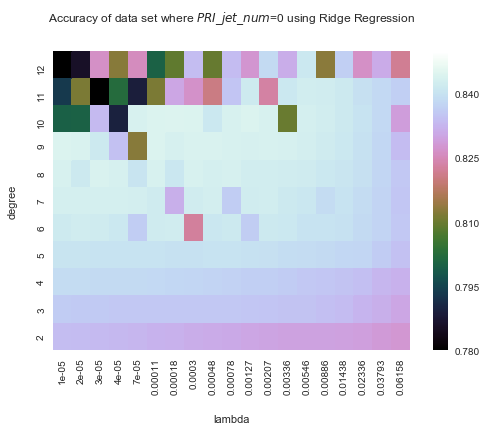

In [24]:
degrees = np.arange(1, 13, 1)
lambdas = np.logspace(-5, -1, 20)

show_ridge_performance(results, degrees, lambdas, '0')

In [ ]:
results.sort(key=lambda x: -x[5])
[x[4] for x in results[:10]]

# Separating into multiple models

With balance before everything (+ nan_to_median + standardize):

* For 0: Best is Ridge (9, 0, 0, 0, 0.00046415888336127773, 0.81200248756218907)
* For 1: Best is Ridge (11, 0, 0, 0, 0.001291549665014884, 0.79104143337066068)
* For 2: Best is Ridge (11, 50, 64, 0, 4.6415888336127818e-05, 0.84399274987053341)
* For 3: Best is Ridge (11, 50, 64, 0, 1.0000000000000001e-05, 0.80668918918918919)

With balance (+ nan_to_median + standardize BUT AFTER SEPARATING DATA):

* For 0: Best is Ridge (8, 50, 64, 0, 0.001, 0.81080816006276968)
* For 1: Best is Ridge (13, 50, 64, 0, 0.001, 0.79271021291952359)
* For 2: Best is Ridge (12, 50, 64, 0, 0.0021544346900318821, 0.83351592615134906)
* For 3: Best is Ridge (10, 50, 64, 0, 0.001, 0.80564635958395248)

With balance before everything (+ nan_to_median + standardize) and with added inv. log:

* For 0: Best is Ridge (11, 50, 64, 0, 0.0001, 0.81401432575521648)
* For 1: Best is Ridge (11, 50, 64, 0, 3.1622776601683795e-05, 0.79476234855545214)
* For 2: Best is Ridge (10, 50, 64, 0, 0.00031622776601683794, 0.84767954368680321)
* For 3: Best is Ridge (9, 50, 64, 0, 0.01, 0.80967741935483883)

Without balance (+ nan_to_median + standardize):

* For 0: Best is Ridge (9, 50, 64, 0, 4.6415888336127818e-05, 0.84248823941547391)
* For 1: Best is Ridge (12, 50, 64, 0, 0.001, 0.80530049006964144)
* For 2: Best is Ridge (12, 50, 64, 0, 0.0021544346900318821, 0.83388921977367492)
* For 3: Best is Ridge (11, 50, 64, 0, 2.1544346900318823e-05, 0.82996389891696754)
* For 2-3: Best is Ridge (11, 50, 64, 0, 0.001, 0.82996967190515569)

Without balance (+ nan_to_median + standardize BUT AFTER SEPARATING DATA):

* For 0: Best is Ridge (8, 50, 64, 0, 2.1544346900318823e-05, 0.84242818536683006)
* For 1: Best is Ridge (12, 50, 64, 0, 0.0021544346900318821, 0.80531338663915408)
* For 2: Best is Ridge (12, 50, 64, 0, 0.00046415888336127773, 0.83325392098471307)
* For 3: Best is Ridge (12, 50, 64, 0, 0.0001, 0.8336642599277978)
* For 2-3: Best is Ridge (12, 50, 64, 0, 0.00046415888336127773, 0.83195478356768682)

Without balance (+ nan_to_median + standardize) and with added inv. log:

* For 0: Best is Ridge (10, 50, 64, 0, 0.00021544346900318823, 0.84473025723150852)
* For 1: Best is Ridge (12, 50, 64, 0, 0.00046415888336127773, 0.80794428681970598)
* For 2: Best is Ridge (9, 50, 64, 0, 1.0000000000000001e-05, 0.83732380385149896)
* For 3: Best is Ridge (10, 50, 64, 0, 0.001, 0.83948555956678705)
* For 2-3: Best is Ridge (10, 50, 64, 0, 0.001, 0.83607664736696985)

Without balance (+ nan_to_median + standardize BUT AFTER SEPARATING DATA) and with added inv. log:

* For 0: Best is Ridge (9, 50, 64, 0, 4.6415888336127818e-05, 0.84425983385046544)
* For 1: Best is Ridge (12, 50, 64, 0, 0.0021544346900318821, 0.80806035594531855)
* For 2-3: Best is Ridge (10, 50, 64, 0, 0.00046415888336127773, 0.83569065343258886)

In [ ]:
# Code to use all models on the test_set and have the final prediction in y_pred

degrees = [10, 12, 9, 10]
lambdas = [0.00021544346900318823, 0.00046415888336127773, 1.0000000000000001e-05, 0.001]

# Final prediction in here
y_pred = np.zeros(x_test.shape[0])

for i in range(len(masks_jet_train)):
    current_tx_train = tx_train.T[masks_jet_train[i]].T
    current_tx_test = tx_test.T[masks_jet_test[i]].T
    current_y_train = y_train[masks_jet_train[i]]
    
    # Preprocess here if not preprocessed before separating
    '''
    # Remove columns full of NaN
    current_tx_train = current_tx_train[~np.all(np.isnan(current_tx_train), axis=1)]
    current_tx_test = current_tx_test[~np.all(np.isnan(current_tx_test), axis=1)]

    # Remove columns without standard deviation at all
    current_tx_train = current_tx_train[np.nanstd(current_tx_train, axis=1) != 0]
    current_tx_test = current_tx_test[np.nanstd(current_tx_test, axis=1) != 0]
    
    # Balance the data set
    #current_tx_train, current_y_train = balance(current_tx_train.T, current_y_train, LOWER_BOUND, UPPER_BOUND)

    # Replace remaining NaN by median
    current_tx_train = replace_nan_by_median(current_tx_train)
    current_tx_test = replace_nan_by_median(current_tx_test)

    # Standardize features
    mean_train, std_train, current_tx_train = standardize(current_tx_train)
    current_tx_test = standardize_predef(current_tx_test, mean_train, std_train)
    '''
    # Build poly
    current_tx_poly_train = build_poly_tx(current_tx_train, degrees[i])
    current_tx_poly_test = build_poly_tx(current_tx_test, degrees[i])
    
    # Compute best method
    current_w, current_loss = ridge_regression(current_y_train, current_tx_poly_train, lambdas[i])
    
    acc = accuracy(current_y_train, current_tx_poly_train.T, current_w, LOWER_BOUND, UPPER_BOUND)
    
    print("Accuracy:", acc)
    
    # Predict
    y_test_pred = predict_labels_kaggle(current_w, current_tx_poly_test.T, LOWER_BOUND, UPPER_BOUND)
    y_pred[masks_jet_test[i]] = y_test_pred.flatten()

print("Number of %d:" % UPPER_BOUND, np.count_nonzero(y_pred == UPPER_BOUND))
print("Number of %d:" % LOWER_BOUND, np.count_nonzero(y_pred == LOWER_BOUND))

# Submission

In [ ]:
create_csv_submission(ids_test, y_pred, "test25.csv")

Test n : algorithm / features / y / w
- - - - - - - - - - - - - - - - - - - 
Test 1 : least_squares / all features standardized / y = -1,1 / random init_w

Test 2 : least_squares / corr > 0.1 features standardized / y = -1,1 / random init_w

Test 3 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w

Test 4 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w / poly, degree=1

Test 5 : least_squares / all features standardized / y = -1,1 / random init_w / median + categorical

Test 6 : logistic_regressoin  /all features standardized / y = 0,1 / random init_w / median + categorical + balanced

Test 7 : least_squares / all features standardized / y = 0,1 / random init_w

Test 8 : Test 1

Test 9 : Test 1

Test 10 : Test 1 / standardized test_set with mean and std from train_set

Test 11 : Test 1 / standardized test_set with mean and std from train_set / balance

Test 12 : Ridge regression / non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11

Test 13 : Ridge regression / balanced / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11

Test 14 : Ridge regression / balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11

Test 15 : Ridge regression / Removed all rows containing at least a NaN / balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11 / Replaced NaN values in test_set by median in test_set

Test 16 : balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / Ensembling with: ("least_squares_GD", 1, 150, 0, 0.01, 0), ("least_squares_GD", 1, 50, 0, 0.25, 0), ("least_squares_SGD", 1, 30, 256, 0.2, 0), ("least_squares_SGD", 1, 60, 64, 0.1, 0), ("ridge_regression", 7, 0, 0, 0, 0.001), ("ridge_regression", 9, 0, 0, 0, 0.001), ("ridge_regression", 11, 0, 0, 0, 0.001)

Test 17 : balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [9, 11, 11, 11] and lambdas = [0.00046415888336127773, 0.001291549665014884, 4.6415888336127818e-05, 1.0000000000000001e-05]

Test 18 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [9, 12, 12, 11] and lambdas = [4.6415888336127818e-05, 0.001, 0.0021544346900318821, 2.1544346900318823e-05]

Test 19 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [8, 12, 12, 11] and lambdas = [2.1544346900318823e-05, 0.0021544346900318821, 0.00046415888336127773, 0.0001]

Test 20 : balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [8, 13, 12, 10] and lambdas = [0.001, 0.001, 0.0021544346900318821, 0.001]

Test 21 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime with degrees = [8, 12, 12] and lambdas = [2.1544346900318823e-05, 0.0021544346900318821, 0.00046415888336127773]

Test 22 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime with degrees = [9, 12, 10] and lambdas = [4.6415888336127818e-05, 0.0021544346900318821, 0.00046415888336127773] / New features being inverse log

Test 23 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime with degrees = [10, 12, 10] and lambdas = [0.00021544346900318823, 0.00046415888336127773, 0.001] / New features being inverse log

Test 24 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [10, 12, 9, 10] and lambdas = [0.00021544346900318823, 0.00046415888336127773, 1.0000000000000001e-05, 0.001] / New features being inverse log

Test 25 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [11, 11, 10, 9] and lambdas = [0.0001, 3.1622776601683795e-05, 0.00031622776601683794, 0.01] / New features being inverse log

## Further work

- balance output (batch numpy)
- median and category
- features engineering : features d'intéraction
- logistic regression 